In [1]:
import numpy as np
from scipy import stats
from scipy import signal
import math
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import os
from os.path import sep

In [2]:
from fly2p_function_TQ.imaging_2p_fixed_heading_period_analysis import find_stop_period_on_heading,PVA_during_stopPeriod,forwrad_speed_during_stopPeriod,bump_amplitude_during_stopPeriod,calculate_angle_difference_between_two_time_point
from fly2p_function_TQ.imaging_2p_fictrac_imaging_alignment import fictrack_signal_decoding

In [3]:
volume_cycle = 2166
volume_time = 0.13851
volume_rate = 1/volume_time
time_array_imaging = np.arange(volume_cycle)/volume_rate

In [4]:
#Read the imaging/behavior data after preprocessing
pd_imaging_behavior_preprocessed = pd.read_csv('/home/tianhaoqiu/Documents/GitHub/2p_analysis/preprocessing_output/normalized/delta7_PB/TQfly028-006-imaging-normalized.csv')
pd_imaging_behavior_preprocessed

,Time_Stamp,F_Roi_1,F_Roi_2,F_Roi_3,F_Roi_4,F_Roi_5,F_Roi_6,F_Roi_7,F_Roi_8,dFF_Roi_1,...,PVA_Radian_offset,PVA_Angle,Angular_Velocity,Bar_Position/Heading,Unwrapped_Bar_Position/Heading,Unwrapped_Radian,Integrated_x,Integrated_y,PVA_strength,Bump_amplitude
0,0.00000,35.977393,48.266597,51.994864,44.786769,43.022696,34.589809,29.889885,37.615225,0.093415,...,1.850479,94.565471,-0.018834,1.236997,1.236997,1.850479,0.766068,-0.239154,0.303399,0.344620
1,0.13851,38.186304,43.617114,46.432406,44.187883,35.715614,31.429098,23.921545,33.622392,0.163934,...,1.409820,69.317603,0.019410,1.234388,1.234388,1.409820,0.746399,-0.233646,0.351108,0.428997
2,0.27702,52.957921,55.973026,49.733764,49.788579,38.984687,34.166244,38.045798,44.580666,0.542999,...,0.764244,32.328805,0.014611,1.242374,1.242374,0.764244,0.759587,-0.233242,0.682639,0.489888
3,0.41553,58.298515,50.158400,60.288105,51.562813,42.311184,38.586465,42.140581,44.539576,0.664505,...,0.844879,36.948868,-0.027951,1.238436,1.238436,0.844879,0.762234,-0.240579,0.733723,0.424417
4,0.55404,57.327723,51.548479,61.107025,47.365320,45.109789,40.438321,42.361211,46.100812,0.687952,...,0.733986,30.595120,0.017349,1.234631,1.234631,0.733986,0.754824,-0.238638,0.816475,0.438966
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2161,299.32011,61.112046,48.720665,79.452121,70.881476,63.114301,47.853470,44.151334,45.844720,0.672191,...,2.498917,131.718229,0.004884,-2.196559,-27.329300,-41.483380,0.624263,-1.347692,0.545114,0.380425
2162,299.45862,60.322112,55.500075,72.167495,66.481337,67.927263,54.337561,48.131422,45.167702,0.754300,...,2.318171,121.362256,-0.003171,-2.196906,-27.329647,-41.664126,0.626188,-1.350614,0.526483,0.385747
2163,299.59713,67.150660,47.347370,76.516402,77.064206,62.589144,53.123818,46.456790,49.313903,0.826768,...,2.294961,120.032451,-0.006786,-2.197437,-27.330178,-41.687336,0.649910,-1.348796,0.503561,0.366359
2164,299.73564,65.078218,44.997153,75.738651,66.389415,71.864643,51.152179,41.694345,52.818761,0.800387,...,2.220989,115.794137,-0.014931,-2.198785,-27.331527,-41.761308,0.670404,-1.352808,0.478532,0.414763


In [5]:
PVA_Unwrapped_Radian = pd_imaging_behavior_preprocessed['Unwrapped_Radian']
PVA_Angle = pd_imaging_behavior_preprocessed['PVA_Angle']
Angular_velocity = pd_imaging_behavior_preprocessed['Angular_Velocity']
integrated_x = pd_imaging_behavior_preprocessed['Integrated_x']
PVA_strength = pd_imaging_behavior_preprocessed['PVA_strength']
Bump_amplitude = pd_imaging_behavior_preprocessed['Bump_amplitude']
Unwrapped_heading = pd_imaging_behavior_preprocessed['Unwrapped_Bar_Position/Heading']

In [6]:
PVA_Unwrapped_Radian_no_series = np.zeros(len(pd_imaging_behavior_preprocessed['Unwrapped_Radian']))
PVA_Angle_no_series = np.zeros(len(pd_imaging_behavior_preprocessed['Unwrapped_Radian']))
Angular_velocity_no_series = np.zeros(len(pd_imaging_behavior_preprocessed['Unwrapped_Radian']))
integrated_x_no_series = np.zeros(len(pd_imaging_behavior_preprocessed['Unwrapped_Radian']))
PVA_strength_no_series = np.zeros(len(pd_imaging_behavior_preprocessed['Unwrapped_Radian']))
Bump_amplitude_no_series = np.zeros(len(pd_imaging_behavior_preprocessed['Unwrapped_Radian']))
Unwrapped_heading_no_series = np.zeros(len(pd_imaging_behavior_preprocessed['Unwrapped_Radian']))
for i in range(len(pd_imaging_behavior_preprocessed['Unwrapped_Radian'])):
    PVA_Unwrapped_Radian_no_series[i] = pd_imaging_behavior_preprocessed['Unwrapped_Radian'][i]
    PVA_Angle[i] = pd_imaging_behavior_preprocessed['PVA_Angle'][i]
    PVA_Angle_no_series[i] = pd_imaging_behavior_preprocessed['PVA_Angle'][i]
    Angular_velocity_no_series[i] = pd_imaging_behavior_preprocessed['Angular_Velocity'][i]
    integrated_x_no_series[i] = pd_imaging_behavior_preprocessed['Integrated_x'][i]
    PVA_strength_no_series[i] = pd_imaging_behavior_preprocessed['PVA_strength'][i]
    Bump_amplitude_no_series[i] = pd_imaging_behavior_preprocessed['Bump_amplitude'][i]
    Unwrapped_heading_no_series[i] = pd_imaging_behavior_preprocessed['Unwrapped_Bar_Position/Heading'][i]


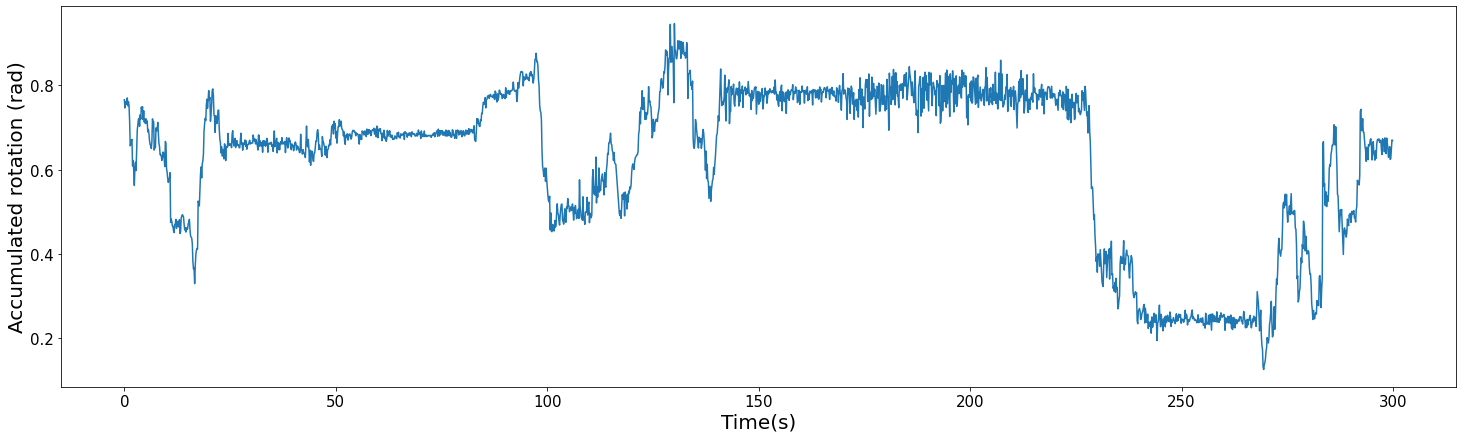

In [7]:
integrated_x_unwrapped =  fictrack_signal_decoding(integrated_x_no_series,time_array_imaging, 10, already_radian = True)
Forward_velocity = np.gradient(integrated_x_unwrapped)/volume_time
Forward_speed_radian = np.abs(Forward_velocity)
Forward_speed_degrees =Forward_speed_radian * 180/np.pi

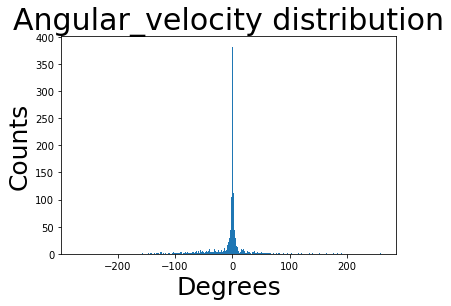

In [8]:
plt.hist(Angular_velocity_no_series*180/np.pi, bins ='auto')
plt.title('Angular_velocity distribution',fontsize = 30)
plt.xlabel('Degrees',fontsize = 25)
plt.ylabel('Counts',fontsize = 25)
plt.show()

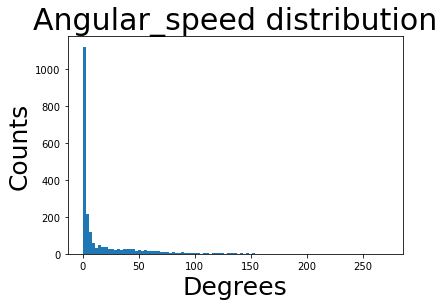

In [9]:
plt.hist(np.abs(Angular_velocity_no_series*180/np.pi), bins ='auto')
plt.title('Angular_speed distribution',fontsize = 30)
plt.xlabel('Degrees',fontsize = 25)
plt.ylabel('Counts',fontsize = 25)
plt.show()

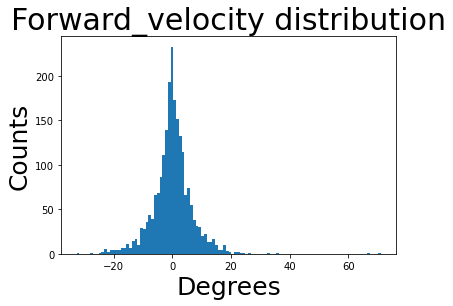

In [10]:
plt.hist(Forward_velocity *180/np.pi ,bins='auto')
plt.title('Forward_velocity distribution', fontsize = 30)
plt.xlabel('Degrees',fontsize = 25)
plt.ylabel('Counts',fontsize = 25)
plt.show()

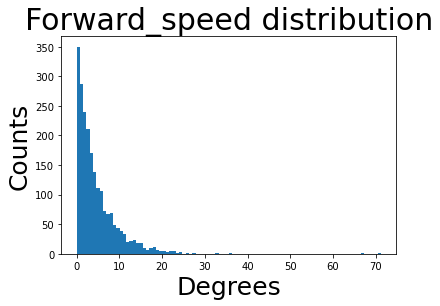

In [11]:
plt.hist(Forward_speed_degrees ,bins='auto')
plt.title('Forward_speed distribution',fontsize = 30)
plt.xlabel('Degrees',fontsize = 25)
plt.ylabel('Counts',fontsize = 25)
plt.show()

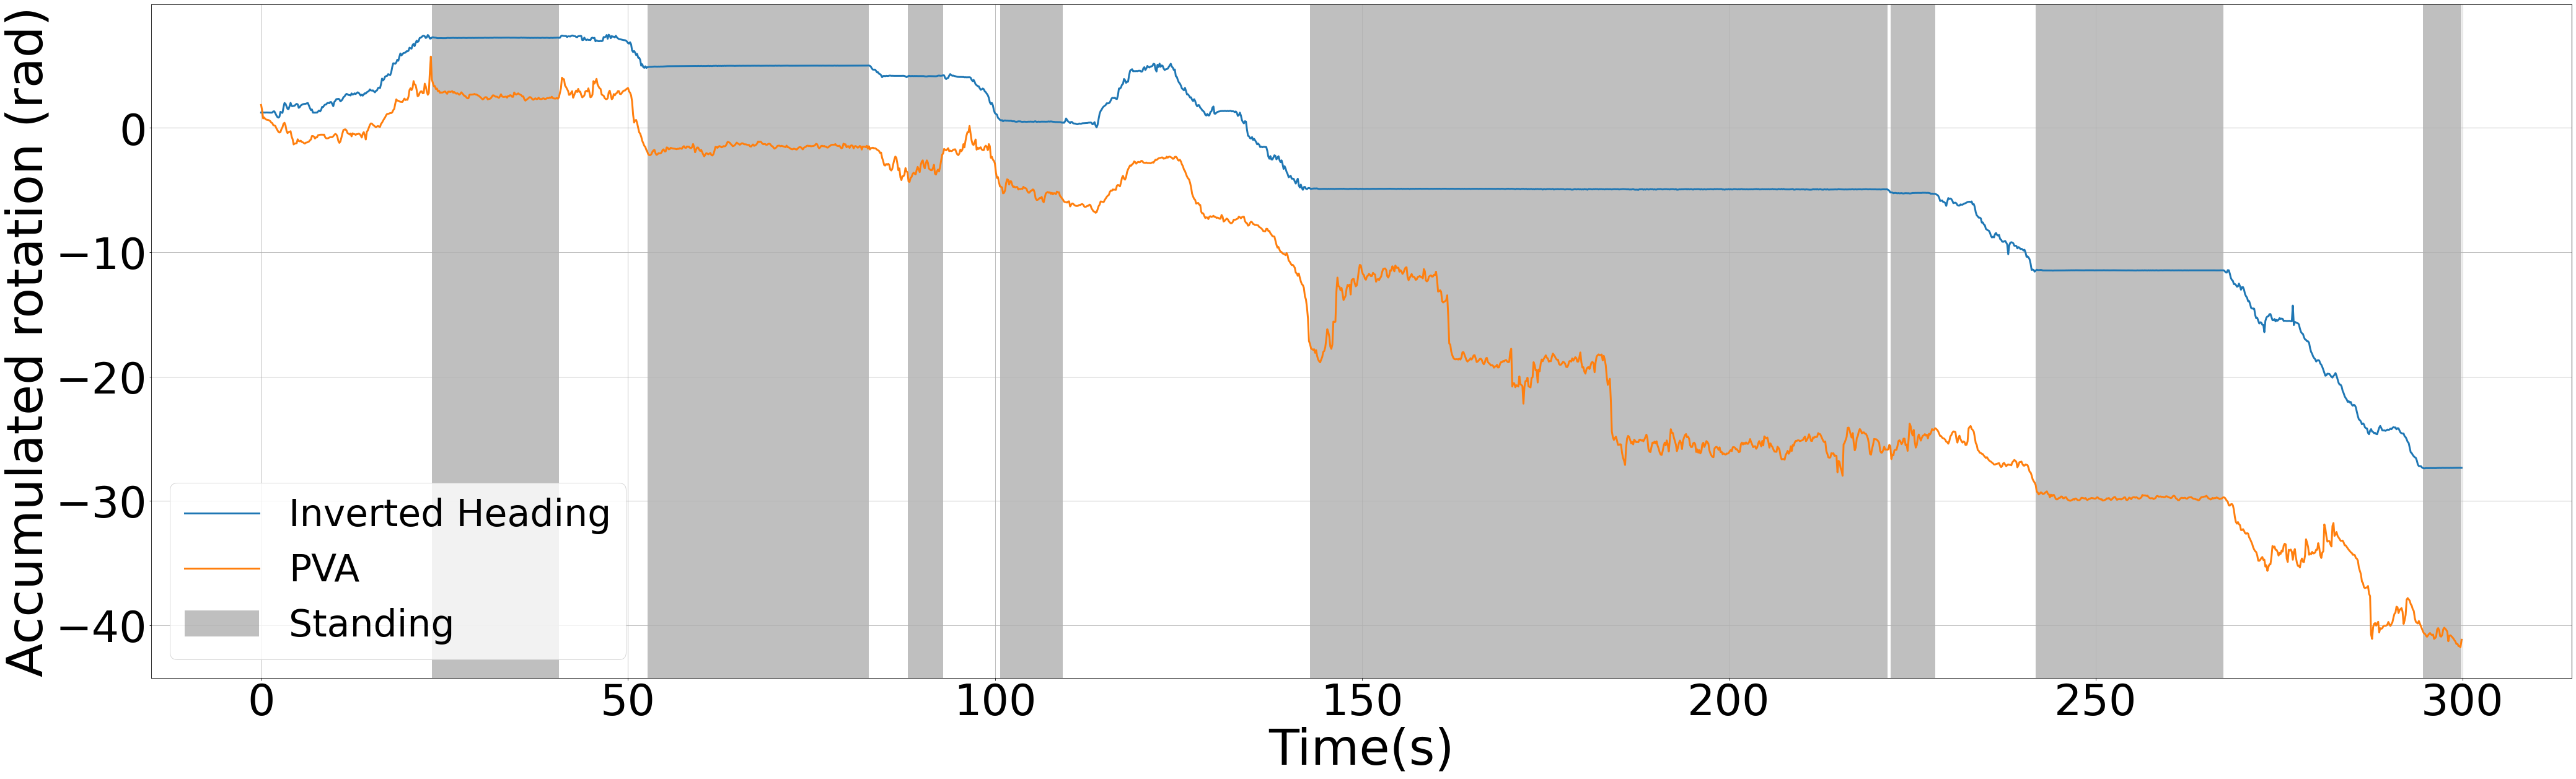

In [12]:
#find stop period and plot as shaded under wrapped PVA/behavior
persistence_stop_index_and_length = find_stop_period_on_heading(head_velocity_array = Angular_velocity,degree_of_tolerance =15,shortest_stopFrame=int(np.ceil(3/volume_time)))
plt.figure(figsize= (70,20))
plt.plot(time_array_imaging,Unwrapped_heading ,linewidth =3)
plt.plot(time_array_imaging, PVA_Unwrapped_Radian,linewidth =3)
#plt.plot(time_array_imaging, Forward_speed_radian,linewidth =3)
plt.xlabel('Time(s)', fontsize=80)
plt.ylabel('Accumulated rotation (rad)', fontsize=80)

#Plot calculated standing period under shaded area
for i in range(len(persistence_stop_index_and_length)):
    plt.axvspan((persistence_stop_index_and_length[i,0]-persistence_stop_index_and_length[i,1])*volume_time, persistence_stop_index_and_length[i,0]*volume_time, color = 'grey', alpha = 0.5, lw =0,label = 'Standing')
plt.legend(['Inverted Heading','PVA','Standing'],fontsize=60)
#plt.legend(['Bar Position','PVA','Standing'],fontsize=60)
plt.xticks(fontsize=70)
plt.yticks(fontsize=70)
plt.grid()
plt.show()

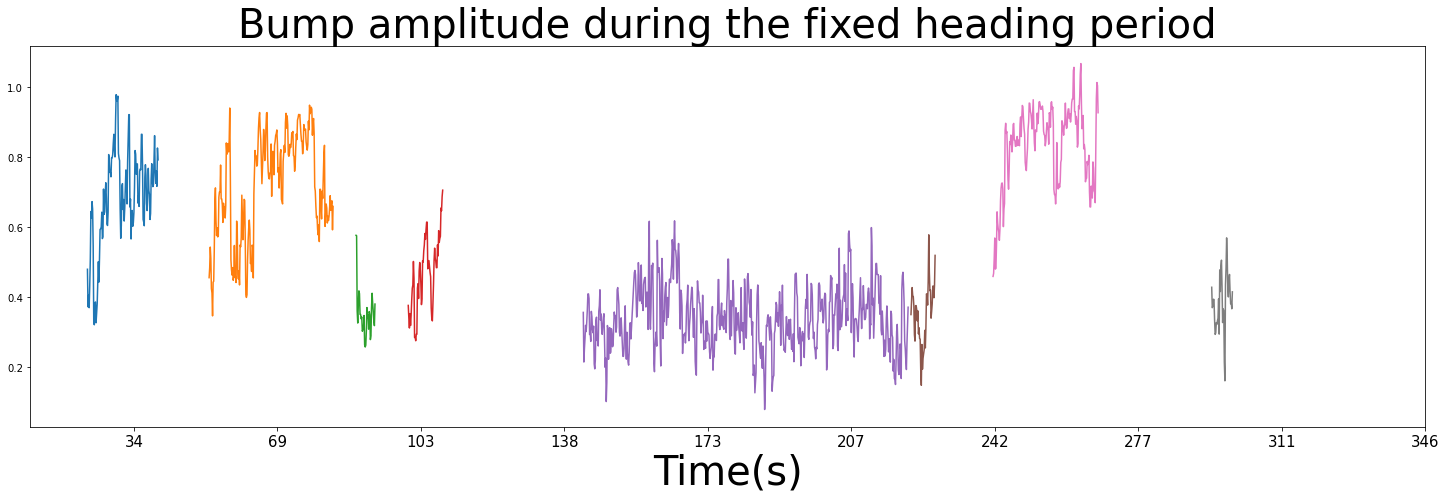

In [13]:
#Check bump amplitude during the time of fixed-heading period
plt.figure(figsize= (25,7))
for i in range(len(persistence_stop_index_and_length)):
    plt.plot(Bump_amplitude[persistence_stop_index_and_length[i,0]-persistence_stop_index_and_length[i,1]+1:persistence_stop_index_and_length[i,0]])
plt.title('Bump amplitude during the fixed heading period', fontsize =40)
plt.xticks(ticks=plt.xticks()[0][1:], labels=np.array(plt.xticks()[0][1:]/volume_rate, dtype=np.int64), fontsize=15)
plt.xlabel('Time(s)', fontsize=40)
plt.show()

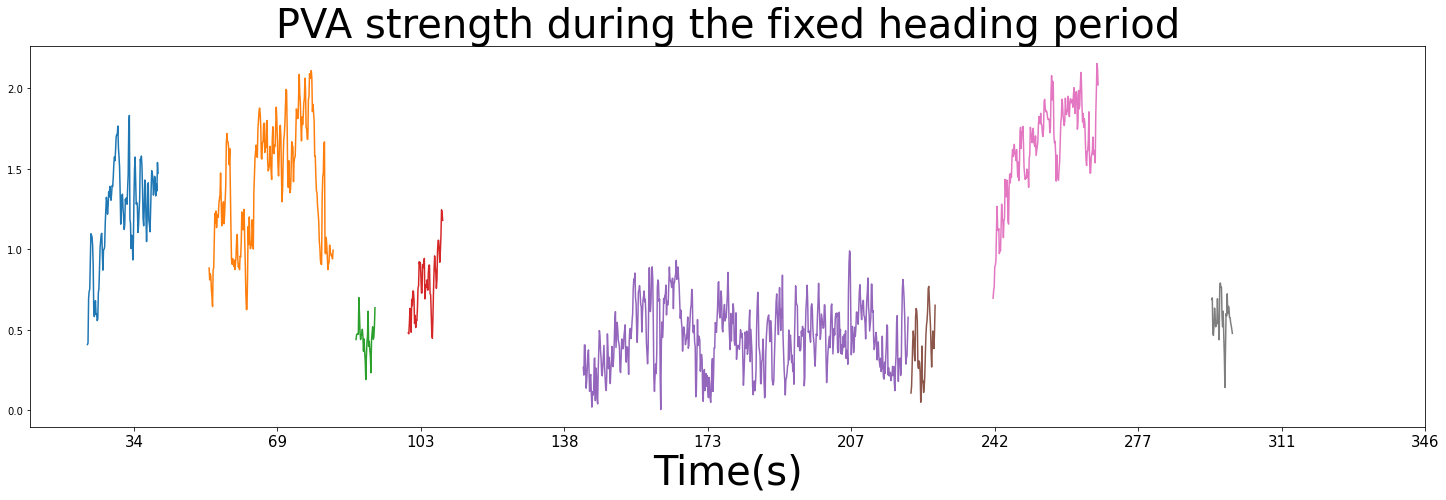

In [14]:
#Check PVA strength during the time of fixed-heading period
plt.figure(figsize= (25,7))
for i in range(len(persistence_stop_index_and_length)):
    plt.plot(PVA_strength[persistence_stop_index_and_length[i,0]-persistence_stop_index_and_length[i,1]+1:persistence_stop_index_and_length[i,0]])
plt.xticks(ticks=plt.xticks()[0][1:], labels=np.array(plt.xticks()[0][1:]/volume_rate, dtype=np.int64), fontsize=15)
plt.title('PVA strength during the fixed heading period', fontsize =40)
plt.xlabel('Time(s)', fontsize=40)
plt.show()
    

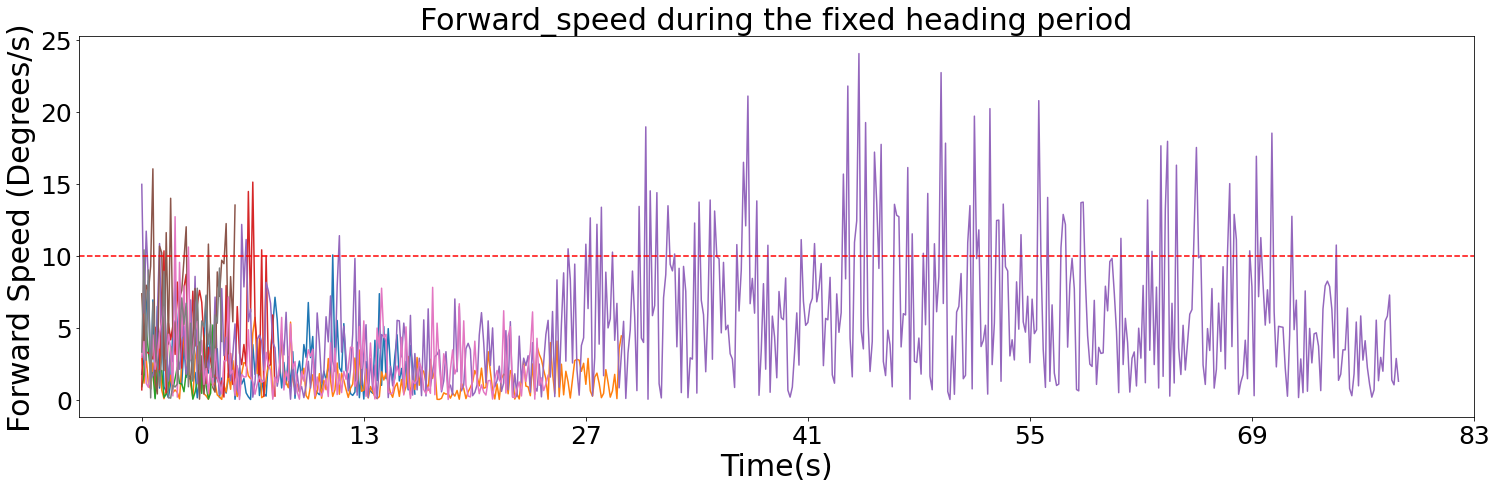

In [15]:
plt.figure(figsize= (25,7))
for i in range(len(persistence_stop_index_and_length)):
    plt.plot(Forward_speed_degrees[persistence_stop_index_and_length[i,0]-persistence_stop_index_and_length[i,1]+1:persistence_stop_index_and_length[i,0]])
plt.xticks(ticks=plt.xticks()[0][1:], labels=np.array(plt.xticks()[0][1:]/volume_rate, dtype=np.int64), fontsize=25)
plt.title('Forward_speed during the fixed heading period', fontsize =30)
plt.axhline(y= 10, color = 'r',linestyle ='--')
plt.xlabel('Time(s)', fontsize=30)
plt.yticks(fontsize=25)
plt.ylabel('Forward Speed (Degrees/s)', fontsize=30)
plt.show()
    

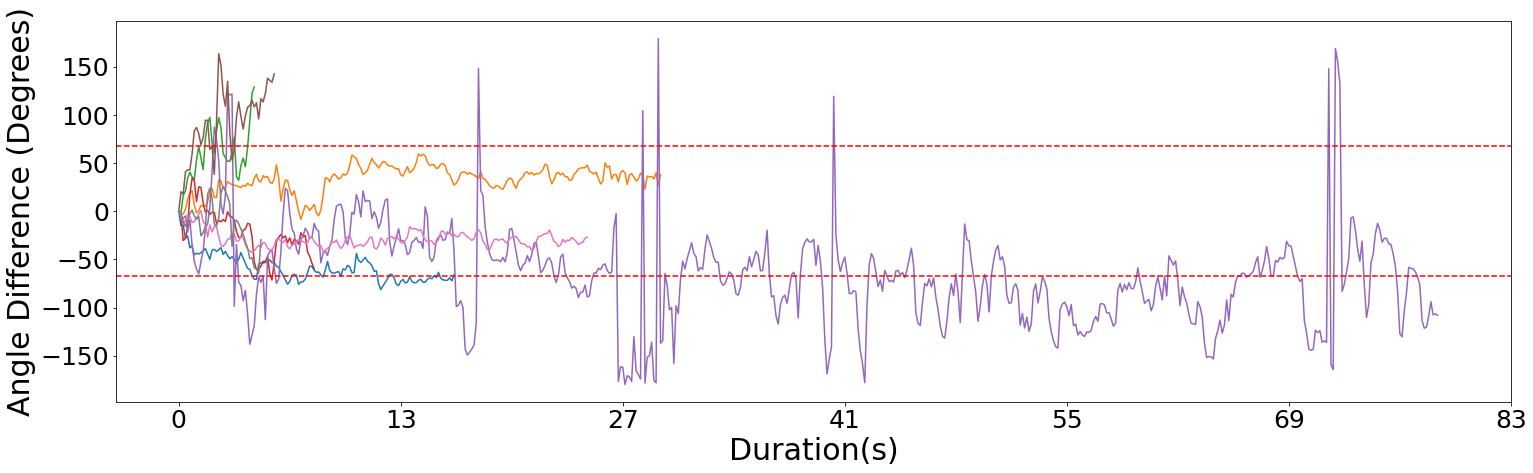

In [16]:
#Calculate annd plot difference throughout the stop period
difference_during_stop = []
current_difference_during_stop = []
current_forward_speed_during_stop = []
forward_speed_during_stop =[]
plt.figure(figsize= (25,7))
for current_index in range(len(persistence_stop_index_and_length)):
    current_stop_PVA = PVA_Angle_no_series[persistence_stop_index_and_length[current_index,0]-persistence_stop_index_and_length[current_index,1]+1]
    current_stop_start_index = persistence_stop_index_and_length[current_index,0]-persistence_stop_index_and_length[current_index,1]+1
    current_difference_during_stop = PVA_Angle_no_series[current_stop_start_index:persistence_stop_index_and_length[current_index,0]+1] - current_stop_PVA
    current_forward_speed_during_stop = Forward_speed_degrees[current_stop_start_index:persistence_stop_index_and_length[current_index,0]+1]
    #Modify the value so angle difference will never be different more than 180 degrees
    for j in range(len(current_difference_during_stop)):
        if np.abs(current_difference_during_stop[j]) > 180:
            if current_difference_during_stop[j] < 0:
                current_difference_during_stop[j] =  current_difference_during_stop[j] + 360
            else:
                current_difference_during_stop[j] =  current_difference_during_stop[j] - 360
    
    difference_during_stop.append(current_difference_during_stop)
    forward_speed_during_stop.append(current_forward_speed_during_stop)
    plt.plot(current_difference_during_stop)

max_length = 0
for i in range(len(difference_during_stop)):
    if max_length < len(difference_during_stop[i]):
        max_length = len(difference_during_stop[i])

time_array_PVA_difference_stop = np.arange(max_length)/volume_rate
plt.axhline(y= 67.5, color = 'r',linestyle ='--')
plt.axhline(y= -67.5, color = 'r',linestyle ='--')
plt.ylabel('Angle Difference (Degrees)', fontsize=30)
plt.xlabel('Duration(s)',fontsize =30)
plt.xticks(ticks=plt.xticks()[0][1:], labels=np.array(plt.xticks()[0][1:]/volume_rate, dtype=np.int64), fontsize=25)
plt.yticks(fontsize=25)
plt.show()
    

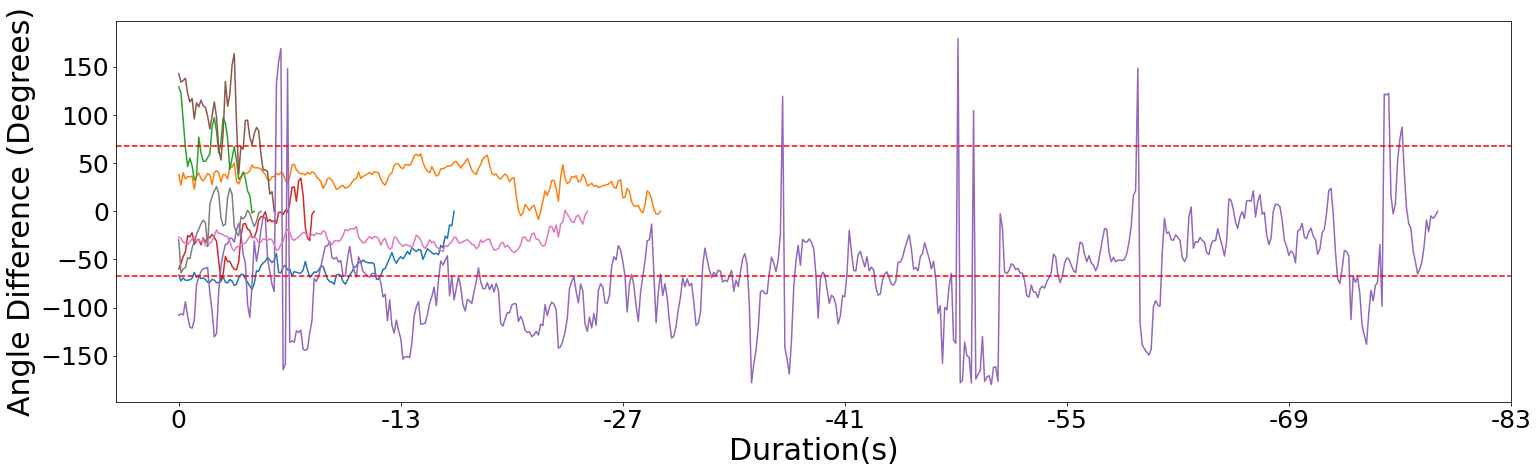

In [17]:
#Plot the reverse of difference during fixed heading period (align at the restart)
plt.figure(figsize= (25,7))
for i in range(len(difference_during_stop)):
    plt.plot(np.flip(difference_during_stop[i]))
             
max_length = 0
for i in range(len(difference_during_stop)):
    if max_length < len(difference_during_stop[i]):
        max_length = len(difference_during_stop[i])

time_array_PVA_difference_stop = np.arange(max_length)/volume_rate
plt.axhline(y= 67.5, color = 'r',linestyle ='--')
plt.axhline(y= -67.5, color = 'r',linestyle ='--')
plt.ylabel('Angle Difference (Degrees)', fontsize=30)
plt.xlabel('Duration(s)',fontsize =30)
plt.xticks(ticks=plt.xticks()[0][1:], labels=np.array(plt.xticks()[0][1:]/-volume_rate, dtype=np.int64), fontsize=25)
plt.yticks(fontsize=25)
plt.show()

In [18]:
PVA_angle_at_stop = PVA_during_stopPeriod(stop_index_array = persistence_stop_index_and_length, PVA_array =PVA_Angle_no_series, volume_time=volume_time)
PVA_angle_at_stop.insert(0,'FlyTrial','TQfly028-006')
PVA_angle_at_stop.insert(1,'Genotype','R55G08>sytGCaMP7f')
PVA_angle_at_stop.insert(2,'TrialType','dark')
PVA_angle_at_stop

,FlyTrial,Genotype,TrialType,Period_duration,PVA_before_stop,PVA_at_restart,PVA_100ms_before_restart,PVA_500ms_before_restart,PVA_in_middle,PVA_2s_before_restart,PVA_3s_after_stop,PVA_5s_after_stop,PVA_10s_after_stop
0,TQfly028-006,R55G08>sytGCaMP7f,dark,17.31375,-164.284422,129.595883,123.380064,124.027599,132.290266,122.050296,154.050687,140.971475,133.122750
1,TQfly028-006,R55G08>sytGCaMP7f,dark,30.19518,-133.871338,-95.985487,-106.830152,-100.341201,-74.274928,-96.289099,-109.043819,-102.256726,-100.512724
2,TQfly028-006,R55G08>sytGCaMP7f,dark,4.84785,101.846249,-129.032169,-135.570212,167.968476,-175.013051,161.601052,157.421419,NaN,NaN
3,TQfly028-006,R55G08>sytGCaMP7f,dark,8.58762,77.558274,17.817641,23.505882,35.515963,59.065758,49.878117,66.906474,17.203443,NaN
4,TQfly028-006,R55G08>sytGCaMP7f,dark,78.67368,53.656593,-54.340184,-52.885205,-40.324167,24.995419,-31.263218,70.282289,-14.627230,60.543957
5,TQfly028-006,R55G08>sytGCaMP7f,dark,6.09444,-97.601198,45.072055,36.413095,40.471661,11.445980,-12.218870,11.445980,-1.728623,NaN
6,TQfly028-006,R55G08>sytGCaMP7f,dark,25.62435,113.228702,86.399794,85.206533,80.325534,83.032475,80.487330,79.745874,77.941741,78.302993
7,TQfly028-006,R55G08>sytGCaMP7f,dark,5.26338,179.939938,150.332298,115.794137,121.362256,172.839585,-172.868443,-158.969911,115.794137,NaN


In [19]:
Forward_speed_at_stop = forwrad_speed_during_stopPeriod(stop_index_array=persistence_stop_index_and_length,forward_speed_array=Forward_speed_degrees, volume_time=volume_time)
Forward_speed_at_stop

,forward_speed_before_stop,forward_speed_at_restart,forward_speed_100ms_before_restart,forward_speed_500ms_before_restart,forward_speed_in_middle,forward_speed_2s_before_restart,forward_speed_3s_after_stop,forward_speed_5s_after_stop,forward_speed_10s_after_stop
0,1.756862,3.958598,0.380591,3.753053,2.627813,1.451660,2.166352,1.490969,1.423152
1,2.935853,7.479492,4.420976,0.060920,1.924045,0.232376,2.387936,0.010184,1.418539
2,0.892676,9.321658,2.899971,0.446203,1.114257,1.904318,1.684397,NaN,NaN
3,0.672405,7.424194,0.238563,2.429271,3.625491,2.331230,1.956740,1.290632,NaN
4,14.958335,5.640552,1.272533,1.021752,0.503434,1.061965,2.605616,7.714413,0.893665
5,7.350359,4.381274,13.517431,8.545408,1.522828,2.325647,1.522828,9.683369,NaN
6,2.928410,3.972895,1.683789,0.621739,1.404703,1.222973,10.601697,0.381763,1.968492
7,3.298607,0.403416,4.037148,5.304458,7.062754,1.299813,0.884419,4.037148,NaN


In [20]:
Bump_amplitude_at_stop = bump_amplitude_during_stopPeriod(stop_index_array=persistence_stop_index_and_length,bump_amplitude_array=Bump_amplitude_no_series, volume_time=volume_time)
Bump_amplitude_at_stop

,bump_amplitude_before_stop,bump_amplitude_at_restart,bump_amplitude_100ms_before_restart,bump_amplitude_500ms_before_restart,bump_amplitude_in_middle,bump_amplitude_2s_before_restart,bump_amplitude_3s_after_stop,bump_amplitude_5s_after_stop,bump_amplitude_10s_after_stop
0,0.479312,0.602761,0.791836,0.716243,0.649991,0.638503,0.511302,0.642366,0.921072
1,0.455276,0.630487,0.658911,0.674928,0.837353,0.631749,0.680381,0.940115,0.495803
2,0.576428,0.379876,0.379876,0.332239,0.262456,0.339311,0.349006,NaN,NaN
3,0.375997,0.764445,0.705333,0.646609,0.564696,0.510512,0.477103,0.503869,NaN
4,0.356048,0.367570,0.370886,0.267692,0.325262,0.250437,0.220483,0.352194,0.326253
5,0.349850,0.653232,0.518978,0.397903,0.224763,0.377005,0.224763,0.359113,NaN
6,0.458867,0.825419,0.926634,1.012946,0.845075,0.657337,0.877104,0.896066,0.839643
7,0.427867,0.449270,0.414763,0.385747,0.429898,0.160513,0.361484,0.414763,NaN


In [21]:
output_df = pd.concat([PVA_angle_at_stop,Forward_speed_at_stop,Bump_amplitude_at_stop], axis=1)
output_df

,FlyTrial,Genotype,TrialType,Period_duration,PVA_before_stop,PVA_at_restart,PVA_100ms_before_restart,PVA_500ms_before_restart,PVA_in_middle,PVA_2s_before_restart,...,forward_speed_10s_after_stop,bump_amplitude_before_stop,bump_amplitude_at_restart,bump_amplitude_100ms_before_restart,bump_amplitude_500ms_before_restart,bump_amplitude_in_middle,bump_amplitude_2s_before_restart,bump_amplitude_3s_after_stop,bump_amplitude_5s_after_stop,bump_amplitude_10s_after_stop
0,TQfly028-006,R55G08>sytGCaMP7f,dark,17.31375,-164.284422,129.595883,123.380064,124.027599,132.290266,122.050296,...,1.423152,0.479312,0.602761,0.791836,0.716243,0.649991,0.638503,0.511302,0.642366,0.921072
1,TQfly028-006,R55G08>sytGCaMP7f,dark,30.19518,-133.871338,-95.985487,-106.830152,-100.341201,-74.274928,-96.289099,...,1.418539,0.455276,0.630487,0.658911,0.674928,0.837353,0.631749,0.680381,0.940115,0.495803
2,TQfly028-006,R55G08>sytGCaMP7f,dark,4.84785,101.846249,-129.032169,-135.570212,167.968476,-175.013051,161.601052,...,NaN,0.576428,0.379876,0.379876,0.332239,0.262456,0.339311,0.349006,NaN,NaN
3,TQfly028-006,R55G08>sytGCaMP7f,dark,8.58762,77.558274,17.817641,23.505882,35.515963,59.065758,49.878117,...,NaN,0.375997,0.764445,0.705333,0.646609,0.564696,0.510512,0.477103,0.503869,NaN
4,TQfly028-006,R55G08>sytGCaMP7f,dark,78.67368,53.656593,-54.340184,-52.885205,-40.324167,24.995419,-31.263218,...,0.893665,0.356048,0.367570,0.370886,0.267692,0.325262,0.250437,0.220483,0.352194,0.326253
5,TQfly028-006,R55G08>sytGCaMP7f,dark,6.09444,-97.601198,45.072055,36.413095,40.471661,11.445980,-12.218870,...,NaN,0.349850,0.653232,0.518978,0.397903,0.224763,0.377005,0.224763,0.359113,NaN
6,TQfly028-006,R55G08>sytGCaMP7f,dark,25.62435,113.228702,86.399794,85.206533,80.325534,83.032475,80.487330,...,1.968492,0.458867,0.825419,0.926634,1.012946,0.845075,0.657337,0.877104,0.896066,0.839643
7,TQfly028-006,R55G08>sytGCaMP7f,dark,5.26338,179.939938,150.332298,115.794137,121.362256,172.839585,-172.868443,...,NaN,0.427867,0.449270,0.414763,0.385747,0.429898,0.160513,0.361484,0.414763,NaN


In [22]:
output_df.to_csv('/home/tianhaoqiu/Documents/GitHub/2p_analysis/fixed_heading_period_data/points_during_stop_period/dark trial/delta7_PB/TQfly028-006-Fixed_Heading_Period.csv',encoding = 'utf-8', index=False)

In [24]:
#Combine all persistence files for pooled analysis and statistics 

pooled_directory = ('/home/tianhaoqiu/Documents/GitHub/2p_analysis/fixed_heading_period_data/points_during_stop_period/cl trial/PEG_PB')
pooled_file_list = []
count = 0
for single_df in os.listdir(pooled_directory):
    if count == 0:
        persistence_data_pooled = pd.read_csv(sep.join([pooled_directory, single_df]))
        count = count + 1
    else:
        current_df = pd.read_csv(sep.join([pooled_directory, single_df]))
        persistence_data_pooled = pd.concat([persistence_data_pooled,current_df], ignore_index=True)
        count = count + 1

persistence_data_pooled
        

,FlyTrial,Genotype,TrialType,Period_duration,PVA_before_stop,PVA_at_restart,PVA_100ms_before_restart,PVA_500ms_before_restart,PVA_in_middle,PVA_2s_before_restart,...,forward_speed_10s_after_stop,bump_amplitude_before_stop,bump_amplitude_at_restart,bump_amplitude_100ms_before_restart,bump_amplitude_500ms_before_restart,bump_amplitude_in_middle,bump_amplitude_2s_before_restart,bump_amplitude_3s_after_stop,bump_amplitude_5s_after_stop,bump_amplitude_10s_after_stop
0,TQfly017-003,SS02191>GCaMP7f,cl,3.06774,44.630697,18.719895,42.719298,-176.137723,35.629128,-165.210278,...,NaN,0.563957,0.397914,0.566276,0.339211,0.460591,0.325932,0.397914,NaN,NaN
1,TQfly017-003,SS02191>GCaMP7f,cl,5.89950,75.795398,95.924640,97.115365,-139.444915,157.639725,-126.615987,...,NaN,0.218113,0.266300,0.244826,0.237506,0.405011,0.225939,0.292873,0.503418,NaN
2,TQfly017-003,SS02191>GCaMP7f,cl,10.26513,-64.829002,-120.449674,-105.389388,170.024151,-150.341041,-66.125925,...,1.027914,0.395285,0.445314,0.437103,0.358875,0.238313,0.510542,0.349856,0.331677,0.307626
3,TQfly017-003,SS02191>GCaMP7f,cl,17.69850,5.905201,-167.410124,-55.954248,43.405490,26.548636,-87.394548,...,9.827752,0.709948,0.440031,0.467370,0.280047,0.504237,0.359082,0.484519,0.479047,0.329718
4,TQfly017-003,SS02191>GCaMP7f,cl,17.69850,-49.249161,-157.444506,-165.636152,86.369923,-93.207974,-106.097324,...,1.948785,0.483085,0.411590,0.355770,0.209664,0.391425,0.477582,0.416568,0.246241,0.576634
5,TQfly017-003,SS02191>GCaMP7f,cl,22.41810,-149.866293,-140.830191,-97.526302,-71.981624,-107.766119,-146.049030,...,1.008129,0.217795,0.367883,0.427764,0.270464,0.231767,0.208133,0.248912,0.445020,0.395894
6,TQfly017-003,SS02191>GCaMP7f,cl,11.44503,-130.171716,-14.600639,-130.175955,-113.782296,-144.015543,-133.295173,...,0.117180,0.303944,0.221445,0.288732,0.379293,0.323252,0.235985,0.400951,0.217474,0.413699
7,TQfly017-003,SS02191>GCaMP7f,cl,84.95280,67.268697,-116.579656,-128.833292,-151.553872,-141.844697,-141.270008,...,0.451105,0.376553,0.534621,0.490083,0.462240,0.427124,0.429073,0.359185,0.464967,0.507132
8,TQfly017-003,SS02191>GCaMP7f,cl,11.56302,-60.173149,-123.783330,-121.746672,-123.867800,-124.078285,-117.672182,...,0.863708,0.267853,0.253913,0.517323,0.449138,0.396730,0.327776,0.460828,0.508843,0.415466
9,TQfly017-003,SS02191>GCaMP7f,cl,7.43337,-108.231870,-108.764794,-155.843591,-105.989390,144.840819,92.110130,...,NaN,0.242787,0.493910,0.441378,0.346472,0.517533,0.407384,0.328593,0.436271,NaN


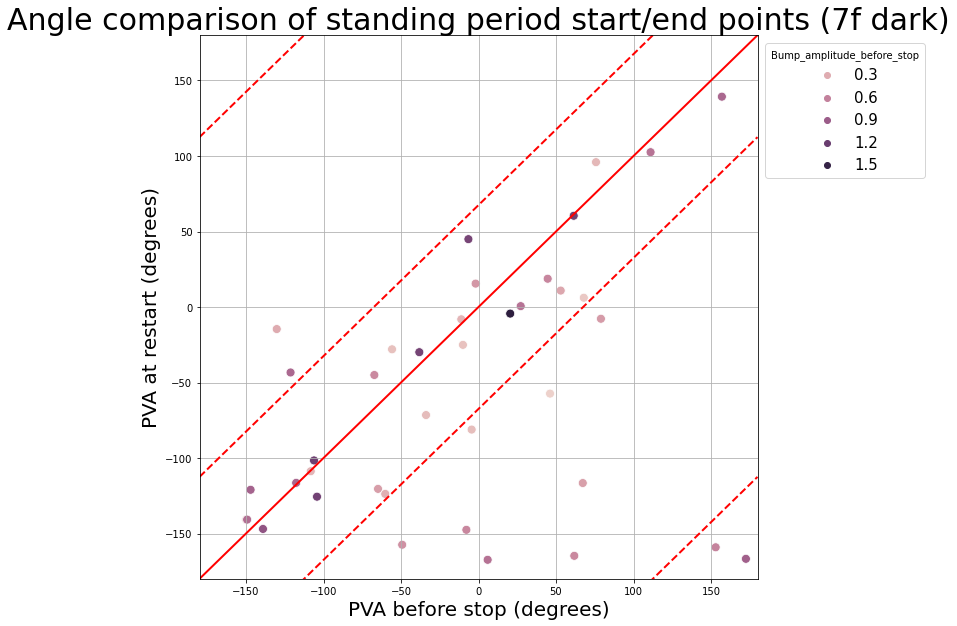

In [25]:
plt.figure(figsize= (10,10))
cmap = sns.cubehelix_palette(rot = -.2, as_cmap = True)
snsplot = sns.scatterplot(data = persistence_data_pooled, x='PVA_before_stop', y='PVA_at_restart', hue = 'bump_amplitude_before_stop', s =80)
snsplot.legend(bbox_to_anchor= (1,1), title = 'Bump_amplitude_before_stop', fontsize = 15)
X_plot = np.linspace(-180, 180, 100)
Y_plot = X_plot
plt.plot(X_plot,Y_plot, color='r', linewidth =2)
plt.plot(X_plot,Y_plot + 67.5, color='r', linestyle ='--', linewidth =2)
plt.plot(X_plot,Y_plot - 67.5, color='r', linestyle ='--', linewidth =2)
plt.plot(X_plot,Y_plot + 292.5, color= 'r', linestyle ='--', linewidth =2)
plt.plot(X_plot,Y_plot - 292.5, color='r', linestyle ='--', linewidth =2)
plt.ylim(-180, 180)
plt.xlim(-180, 180)
plt.title('Angle comparison of standing period start/end points (7f dark)', fontsize =30)
plt.ylabel('PVA at restart (degrees)',fontsize= 20)
plt.xlabel('PVA before stop (degrees)',fontsize= 20)
#plt.setp(snsplot.get_legend().get_texts(), fontsize = 10)
plt.grid()
plt.show()

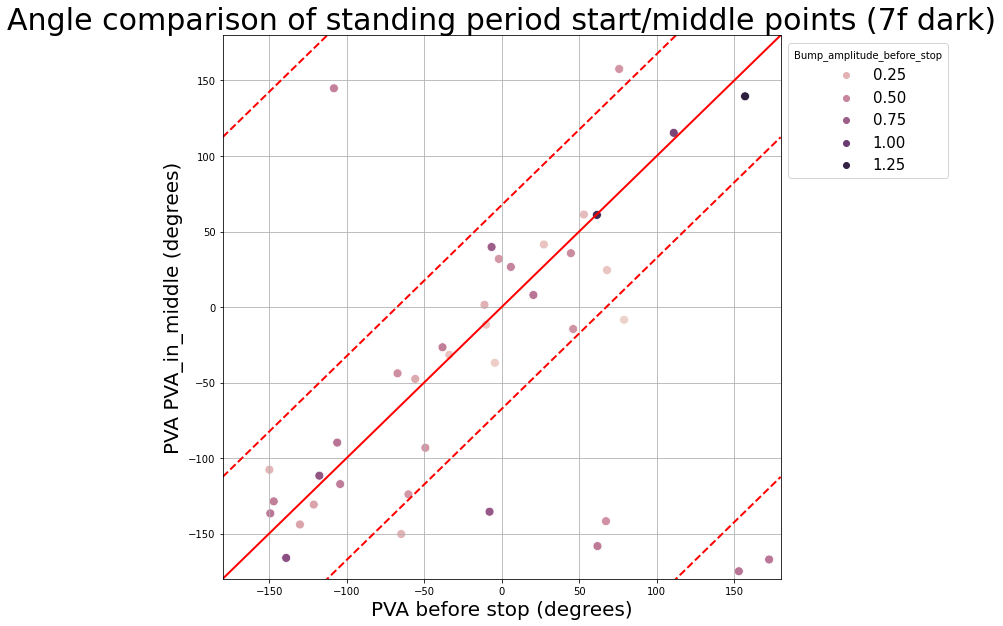

In [26]:
plt.figure(figsize= (10,10))
cmap = sns.cubehelix_palette(rot = -.2, as_cmap = True)
snsplot = sns.scatterplot(data = persistence_data_pooled, x='PVA_before_stop', y='PVA_in_middle', hue = 'bump_amplitude_in_middle', s =80)
snsplot.legend(bbox_to_anchor= (1,1), title = 'Bump_amplitude_before_stop', fontsize = 15)
X_plot = np.linspace(-180, 180, 100)
Y_plot = X_plot
plt.plot(X_plot,Y_plot, color='r', linewidth =2)
plt.plot(X_plot,Y_plot + 67.5, color='r', linestyle ='--', linewidth =2)
plt.plot(X_plot,Y_plot - 67.5, color='r', linestyle ='--', linewidth =2)
plt.plot(X_plot,Y_plot + 292.5, color='r', linestyle ='--', linewidth =2)
plt.plot(X_plot,Y_plot - 292.5, color='r', linestyle ='--', linewidth =2)
plt.ylim(-180, 180)
plt.xlim(-180, 180)
plt.title('Angle comparison of standing period start/middle points (7f dark)', fontsize =30)
plt.ylabel('PVA PVA_in_middle (degrees)',fontsize= 20)
plt.xlabel('PVA before stop (degrees)',fontsize= 20)
#plt.setp(snsplot.get_legend().get_texts(), fontsize = 10)
plt.grid()
plt.show()

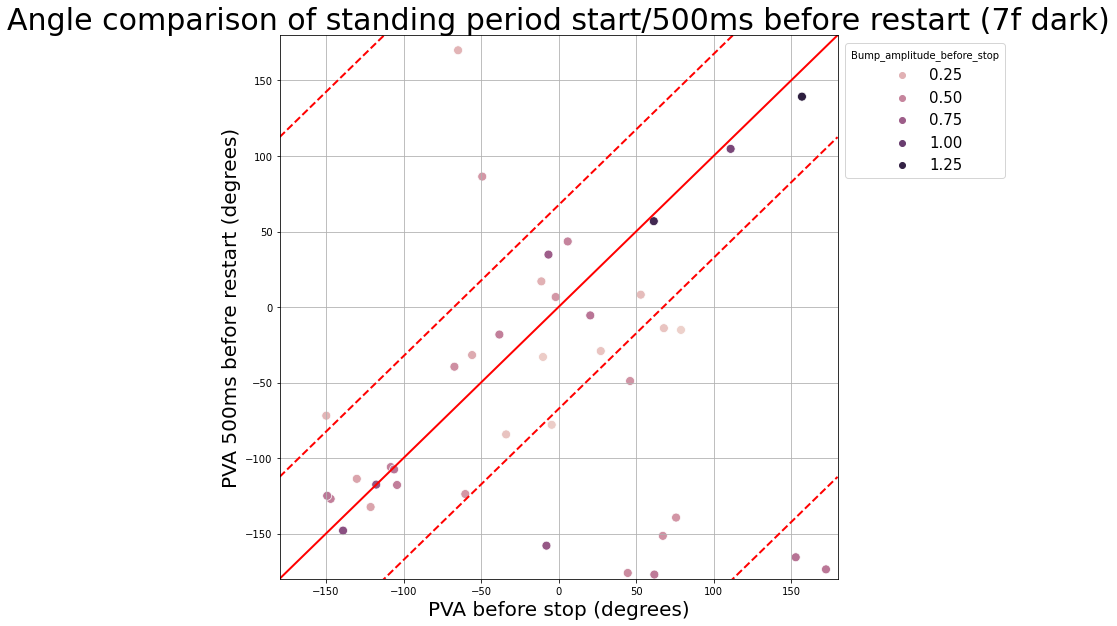

In [27]:
plt.figure(figsize= (10,10))
cmap = sns.cubehelix_palette(rot = -.2, as_cmap = True)
snsplot = sns.scatterplot(data = persistence_data_pooled, x='PVA_before_stop', y='PVA_500ms_before_restart', hue = 'bump_amplitude_in_middle', s =80)
snsplot.legend(bbox_to_anchor= (1,1), title = 'Bump_amplitude_before_stop', fontsize = 15)
X_plot = np.linspace(-180, 180, 100)
Y_plot = X_plot
plt.plot(X_plot,Y_plot, color='r', linewidth =2)
plt.plot(X_plot,Y_plot + 67.5, color='r', linestyle ='--', linewidth =2)
plt.plot(X_plot,Y_plot - 67.5, color='r', linestyle ='--', linewidth =2)
plt.plot(X_plot,Y_plot + 292.5, color='r', linestyle ='--', linewidth =2)
plt.plot(X_plot,Y_plot - 292.5, color='r', linestyle ='--', linewidth =2)
plt.ylim(-180, 180)
plt.xlim(-180, 180)
plt.title('Angle comparison of standing period start/500ms before restart (7f dark)', fontsize =30)
plt.ylabel('PVA 500ms before restart (degrees)',fontsize= 20)
plt.xlabel('PVA before stop (degrees)',fontsize= 20)
#plt.setp(snsplot.get_legend().get_texts(), fontsize = 10)
plt.grid()
plt.show()

In [39]:
persistence_data_pooled['angle difference start/middle'] = calculate_angle_difference_between_two_time_point(persistence_data_pooled['PVA_before_stop'],persistence_data_pooled['PVA_in_middle'])

In [40]:
persistence_data_pooled['angle difference start/end'] = calculate_angle_difference_between_two_time_point(persistence_data_pooled['PVA_before_stop'],persistence_data_pooled['PVA_at_restart'])

In [41]:
persistence_data_pooled

,FlyTrial,Genotype,TrialType,Period_duration,PVA_before_stop,PVA_at_restart,PVA_100ms_before_restart,PVA_500ms_before_restart,PVA_in_middle,PVA_2s_before_restart,...,bump_amplitude_at_restart,bump_amplitude_100ms_before_restart,bump_amplitude_500ms_before_restart,bump_amplitude_in_middle,bump_amplitude_2s_before_restart,bump_amplitude_3s_after_stop,bump_amplitude_5s_after_stop,bump_amplitude_10s_after_stop,angle difference start/middle,angle difference start/end
0,TQfly008-001,R60D05>GCaMP7f,dark,4.41160,125.806114,78.827972,96.429436,96.757380,138.129865,124.823581,...,0.401611,0.401611,0.334226,0.397343,0.320035,0.317885,NaN,NaN,12.323751,-46.978142
1,TQfly008-001,R60D05>GCaMP7f,dark,8.82320,-48.818487,-45.564907,-48.324934,-47.704997,-56.515051,-53.260303,...,0.621296,0.570424,0.608027,0.832388,0.652891,0.932168,0.782024,NaN,-7.696564,3.253581
2,TQfly008-001,R60D05>GCaMP7f,dark,33.63845,-58.565712,-64.169146,-65.107538,-64.422098,-69.393475,-74.578530,...,0.486424,0.522143,0.525619,0.666470,0.447305,0.764467,0.661893,0.521532,-10.827762,-5.603434
3,TQfly008-001,R60D05>GCaMP7f,dark,38.49121,-130.866953,177.441434,-171.017050,-155.771560,-131.477922,-141.355446,...,0.190658,0.199186,0.159010,0.232916,0.160620,0.575026,0.515307,0.335133,-0.610969,-51.691613
4,TQfly008-001,R60D05>GCaMP7f,dark,11.58045,7.856330,-29.075006,-48.769241,-36.285890,-35.119945,-33.593439,...,0.296048,0.382340,0.319932,0.450515,0.516107,0.427080,0.440467,0.449214,-42.976275,-36.931336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,TQfly008-008,R60D05>GCaMP7f,dark,52.01224,-132.163524,130.418369,106.662823,110.836994,98.709345,125.215669,...,0.310777,0.283528,0.286140,0.478170,0.323116,0.544774,0.793428,0.533902,-129.127131,-97.418107
88,TQfly008-008,R60D05>GCaMP7f,dark,38.41362,-71.986172,115.770556,112.723257,99.084555,31.380839,121.534169,...,0.432247,0.381000,0.436475,0.188005,0.496214,0.282924,0.357748,0.489467,103.367011,-172.243272
89,TQfly008-008,R60D05>GCaMP7f,dark,28.38836,-60.214354,3.727590,51.323557,-33.084335,4.911885,54.852544,...,0.221208,0.125606,0.226577,0.428719,0.238557,0.377013,0.460497,0.183223,65.126238,63.941943
90,TQfly008-008,R60D05>GCaMP7f,dark,43.17810,16.320039,29.171250,22.783839,32.143382,38.313075,23.613030,...,0.708619,0.676062,0.803716,0.734474,0.463269,1.609003,1.218190,1.067343,21.993036,12.851211


In [42]:
persistence_data_pooled.to_csv('/home/tianhaoqiu/Documents/persistence_data_pooled_EPG_7f_PB_dark.csv',encoding = 'utf-8', index=False)